In [992]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import radius_neighbors_graph, NearestNeighbors
import networkx as nx
import scipy
import numpy as np
import plotly.graph_objs as go
import plotly.offline as pyo

In [993]:
data_path = '/home/avsngh/Mathematical Statistics/Masters-Projects/Unsupervised-Learning/Data/Star_Data.txt'
data = pd.read_csv(filepath_or_buffer=data_path, sep='\s+', header=None)
data.columns = ['col1','col2']
data_df=pd.DataFrame.from_dict(data)


<>:2: SyntaxWarning:

invalid escape sequence '\s'

<>:2: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_872/3623845212.py:2: SyntaxWarning:

invalid escape sequence '\s'



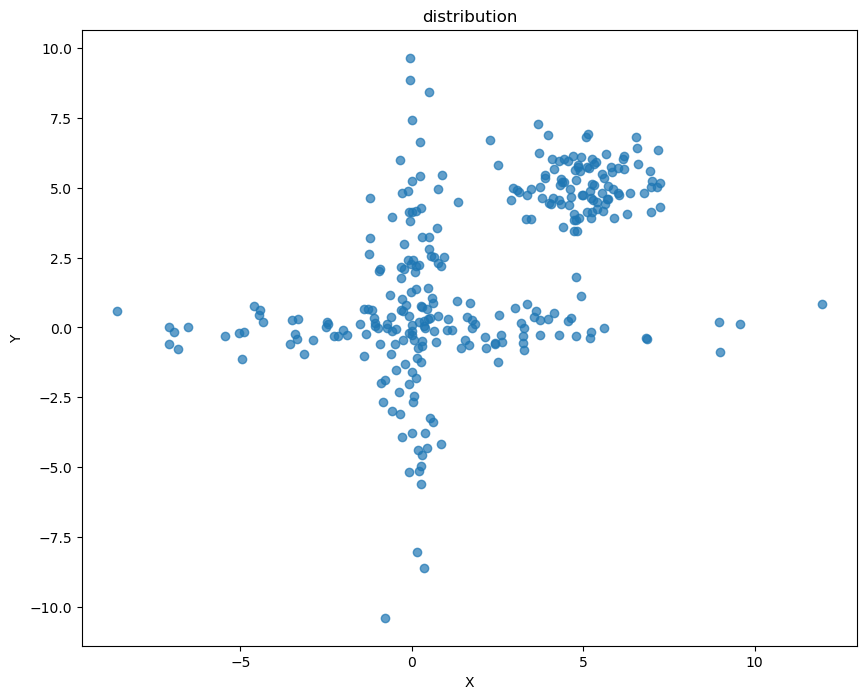

In [994]:
plt.figure(figsize=(10,8))
plt.scatter(data_df['col1'], data_df['col2'], marker='o', alpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('distribution')
plt.show()


## Creating ε neighbourhood graph

In [995]:
epsilon = 3
sim_matrix = radius_neighbors_graph(X=data_df, radius= epsilon, mode='distance', metric='euclidean', n_jobs=-1)

In [996]:
# using networkx library we create a graph which we will visualize in the next step
nx_graph = nx.from_scipy_sparse_array(sim_matrix)
coordinates_dict={}
coordinates_dict = {i: [data_df.at[i, 'col1'], data_df.at[i, 'col2']] for i in range(len(data))}


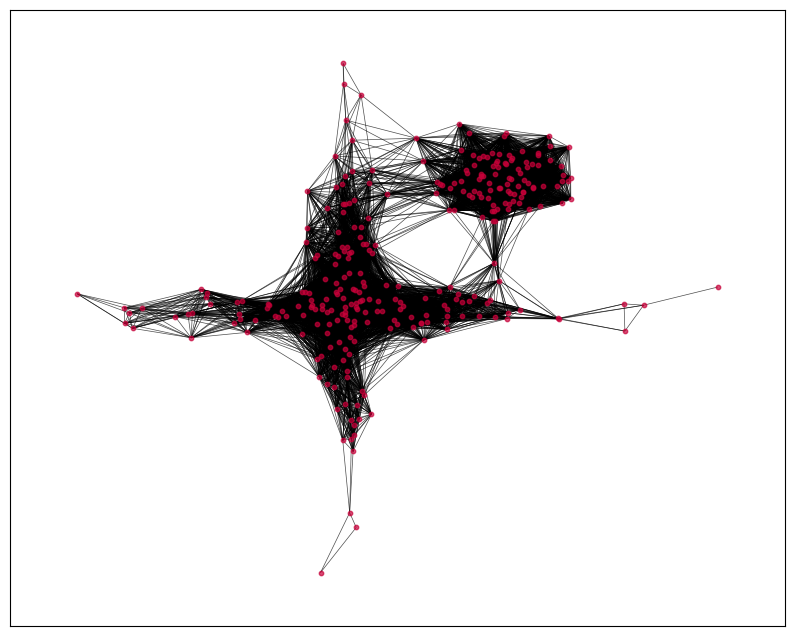

In [997]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(G=nx_graph,pos=coordinates_dict, with_labels= False, node_size = 10, node_color= '#C70039', alpha = 0.7, width =0.5)

plt.show()

In [998]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def create_weighted_adjacency_matrix(data, k=5, similarity='gaussian', sigma=1.0, epsilon=1e-5, custom_similarity_func=None):
    """
    Creates a weighted adjacency matrix from data using a specified or custom similarity function.

    Parameters:
    - data: numpy array of shape (n_samples, n_features)
        The input data.
    - k: int, optional (default=5)
        Number of nearest neighbors to consider for each point.
    - similarity: str, optional (default='gaussian')
        The similarity function to use. Options are:
        - 'gaussian': Gaussian (RBF) similarity.
        - 'inverse_distance': Inverse distance similarity.
        - 'cosine': Cosine similarity.
        - 'custom': Use a custom similarity function provided via `custom_similarity_func`.
    - sigma: float, optional (default=1.0)
        Parameter for the Gaussian kernel.
    - epsilon: float, optional (default=1e-5)
        Small constant to prevent division by zero in inverse distance similarity.
    - custom_similarity_func: callable, optional
        A custom similarity function that takes in distances and returns weights.

    Returns:
    - W: numpy array of shape (n_samples, n_samples)
        The weighted adjacency matrix.
    """
    N = data.shape[0]
    
    # Determine the appropriate metric and preprocessing based on the similarity function
    if similarity == 'cosine':
        metric = 'cosine'
        # Normalize data for cosine similarity
        from sklearn.preprocessing import normalize
        data_normalized = normalize(data)
        data_to_use = data_normalized
    else:
        metric = 'euclidean'
        data_to_use = data

    # Compute the nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric=metric).fit(data_to_use)
    distances, indices = nbrs.kneighbors(data_to_use)

    # Initialize the weighted adjacency matrix
    W = np.zeros((N, N))

    # Define default similarity functions
    def gaussian_similarity(distance):
        return np.exp(- (distance ** 2) / (2 * sigma ** 2))

    def inverse_distance_similarity(distance):
        return 1.0 / (distance + epsilon)

    def cosine_similarity(cosine_distance):
        return 1.0 - cosine_distance

    # Choose the similarity function
    if similarity == 'gaussian':
        sim_func = gaussian_similarity
    elif similarity == 'inverse_distance':
        sim_func = inverse_distance_similarity
    elif similarity == 'cosine':
        sim_func = cosine_similarity
    elif similarity == 'custom':
        if custom_similarity_func is not None:
            sim_func = custom_similarity_func
        else:
            raise ValueError("Custom similarity function must be provided when similarity='custom'.")
    else:
        raise ValueError("Invalid similarity function. Choose 'gaussian', 'inverse_distance', 'cosine', or 'custom'.")

    # Populate the weighted adjacency matrix
    for i in range(N):
        for idx, j in enumerate(indices[i]):
            if i != j:  # Exclude self-loops
                distance = distances[i][idx]
                weight = sim_func(distance)
                W[i][j] = weight
                W[j][i] = weight  # For undirected graph

    return W

In [999]:
sim_matrix_knn = create_weighted_adjacency_matrix(data=np.array(data), k=20, sigma= 0.7)
sim_matrix_knn = csr_matrix(sim_matrix_knn)

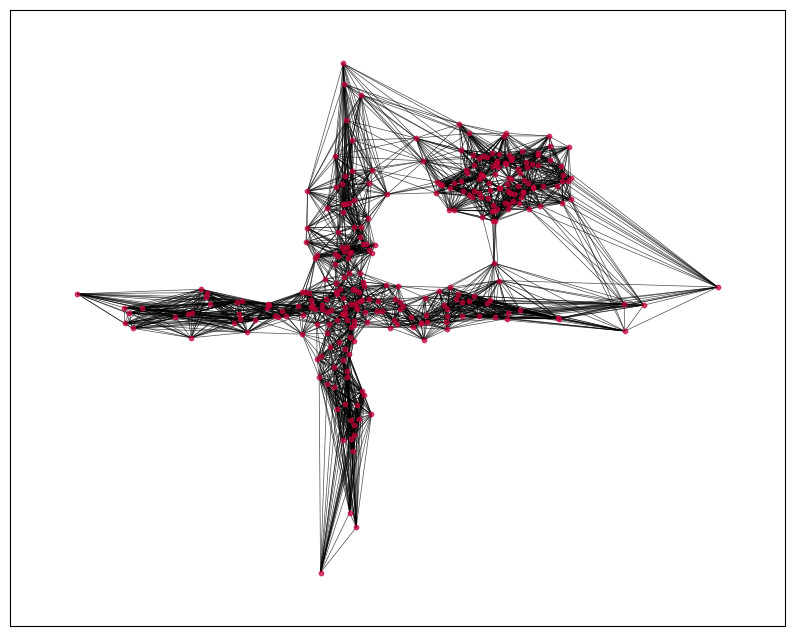

In [1000]:

nx_graph_knn = nx.from_scipy_sparse_array(sim_matrix_knn)

plt.figure(figsize=(10, 8))
nx.draw_networkx(G=nx_graph_knn,pos=coordinates_dict, with_labels= False, node_size = 10, node_color= '#C70039', alpha = 0.7, width =0.5)

plt.show()

In [1001]:
def is_symmetric(csr_matrix):
    return (csr_matrix != csr_matrix.transpose()).nnz == 0

In [1002]:
is_symmetric(sim_matrix_knn)

True

In [1003]:
def create_degree_matrix(csr_weight_matrix):
    number_of_vertices = csr_weight_matrix.get_shape()[0]
    degree_sums = []
    for i in range(number_of_vertices):
        degree = scipy.sparse.csr_matrix.sum(csr_weight_matrix.getrow(i))
        degree_sums.append(degree)
    degree_matrix = np.diag(degree_sums)
    return degree_matrix

def eigenspace_calculation(matrix, k: int = 1):
    np.random.seed(42)
    v0 = np.random.rand(matrix.shape[0])
    eigenvals,eigenvects = scipy.sparse.linalg.eigs(matrix, k=k, which='SM', v0=v0, maxiter=20000)
    return eigenvals, eigenvects


In [1004]:
degree_matrix = create_degree_matrix(sim_matrix_knn)


In [1005]:
unnorm_laplacian_matrix=degree_matrix-sim_matrix_knn

In [1006]:
eigenvals,eigenvects = eigenspace_calculation(matrix=unnorm_laplacian_matrix, k=4)

In [1007]:
eigenvector_1=eigenvects[:,1]
eigenvector_2=eigenvects[:,2]
two_eig_df = pd.DataFrame(np.column_stack((eigenvector_1, eigenvector_2)), columns=['eigenvect1', 'eigenvect2'])

In [1008]:
epsilon = 1e-12

# Count eigenvalues close to zero
zero_eigenvalues = np.sum(np.abs(eigenvals) < epsilon)
print(f"Number of zero eigenvalues: {zero_eigenvalues}")

Number of zero eigenvalues: 1


/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/pandas/core/series.py:1031: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning:

Casting complex values to real discards the imaginary part



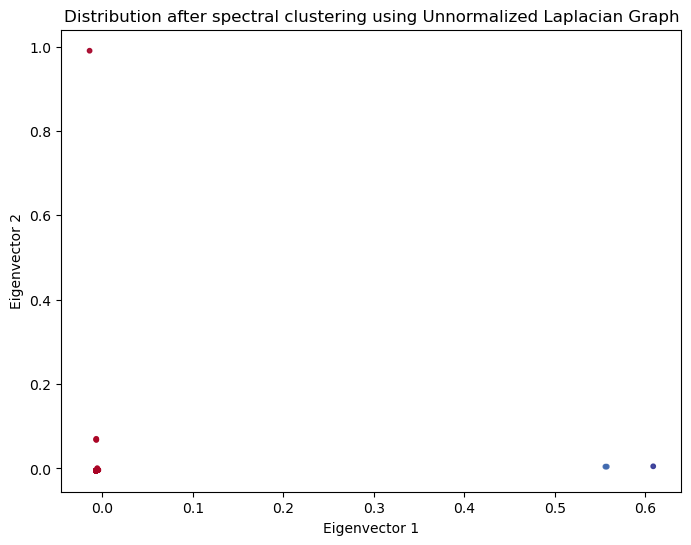

In [1009]:
plt.figure(figsize=(8,6))
plt.scatter(two_eig_df['eigenvect1'], two_eig_df['eigenvect2'], marker='o', alpha=0.9, c=two_eig_df['eigenvect1'], cmap='RdYlBu', s=10)
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.title('Distribution after spectral clustering using Unnormalized Laplacian Graph')
plt.show()

In [1010]:
two_eig_df['eigenvect1'] = two_eig_df['eigenvect1'].apply(lambda val: val.real)
two_eig_df['eigenvect2']= two_eig_df['eigenvect2'].apply(lambda val: val.real)

k = 2  # Number of clusters, you can adjust this value
kmeans = KMeans(n_clusters=k, random_state=42)
two_eig_df['cluster'] = kmeans.fit_predict(two_eig_df[['eigenvect1', 'eigenvect2']])

colors = two_eig_df['cluster'].array

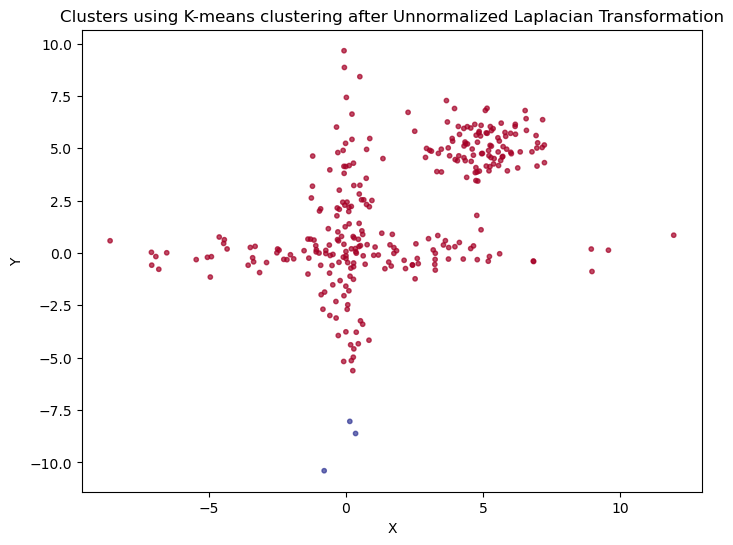

In [1011]:
plt.figure(figsize=(8,6))
plt.scatter(data_df['col1'], data_df['col2'], marker='o', alpha=0.7, c=colors, cmap='RdYlBu', s=10 )
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clusters using K-means clustering after Unnormalized Laplacian Transformation')
plt.show()

### Part 1.C

In [1012]:
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(degree_matrix)))

# Calculate D^(-1/2) * L * D^(-1/2)
normalized_L = D_inv_sqrt @ unnorm_laplacian_matrix @ D_inv_sqrt


In [1013]:
norm_eigenvals, norm_eigenvects = eigenspace_calculation(matrix=normalized_L, k=3)
norm_eigenvector_1=norm_eigenvects[:,1]
norm_eigenvector_2=norm_eigenvects[:,2]
norm_two_eig_df = pd.DataFrame(np.column_stack((norm_eigenvector_1, norm_eigenvector_2)), columns=['eigenvect1', 'eigenvect2'])


/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning:

Casting complex values to real discards the imaginary part



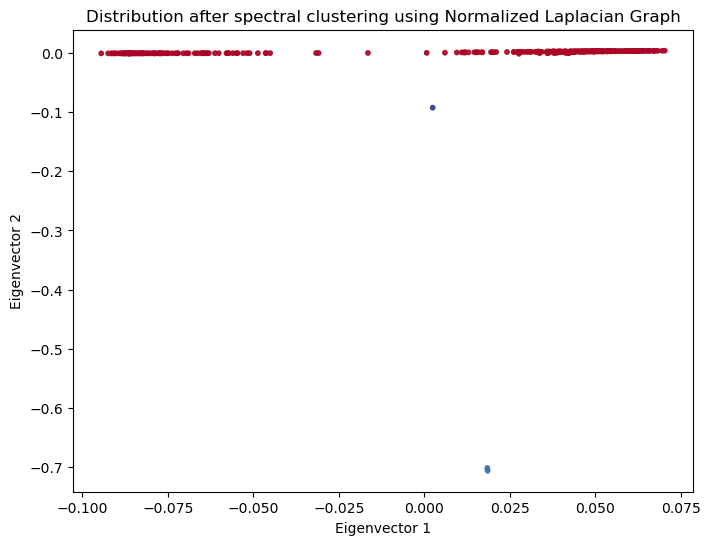

In [1014]:
plt.figure(figsize=(8,6))
plt.scatter(norm_two_eig_df['eigenvect1'], norm_two_eig_df['eigenvect2'], marker='o', alpha=0.9, c=two_eig_df['eigenvect1'], cmap='RdYlBu', s=10)
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.title('Distribution after spectral clustering using Normalized Laplacian Graph')
plt.show()

In [1015]:
norm_two_eig_df['eigenvect1'] = norm_two_eig_df['eigenvect1'].apply(lambda val: val.real)
norm_two_eig_df['eigenvect2']= norm_two_eig_df['eigenvect2'].apply(lambda val: val.real)

k = 2  # Number of clusters, you can adjust this value
kmeans = KMeans(n_clusters=k, random_state=42)
norm_two_eig_df['cluster'] = kmeans.fit_predict(norm_two_eig_df[['eigenvect1', 'eigenvect2']])

norm_colors = norm_two_eig_df['cluster'].array

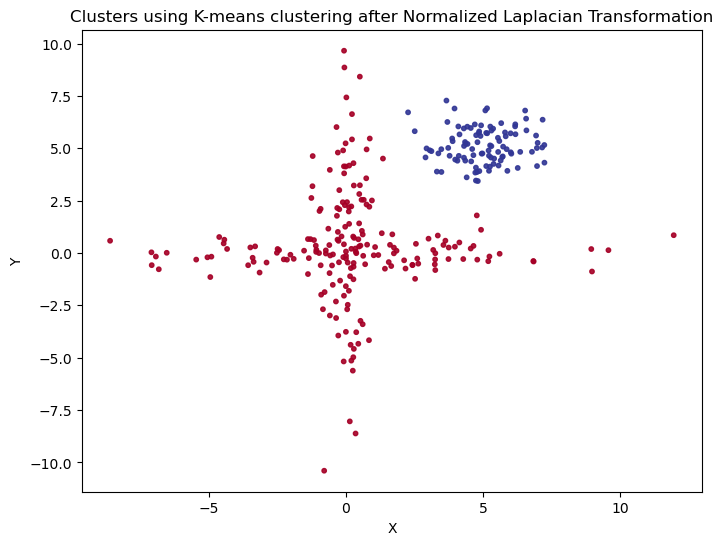

In [1016]:
plt.figure(figsize=(8,6))
plt.scatter(data_df['col1'], data_df['col2'], marker='o', alpha=0.9, c=norm_colors, cmap='RdYlBu', s=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clusters using K-means clustering after Normalized Laplacian Transformation')
plt.show()

## Part 2

In [1017]:
data_path = '/home/avsngh/Mathematical Statistics/Masters-Projects/Unsupervised-Learning/Data/Swiss_Roll.txt'
swiss_roll_data = pd.read_csv(filepath_or_buffer=data_path, sep='\s+', header=None)
swiss_roll_data.columns = ['col1','col2', 'col3']
swiss_roll_data_df=pd.DataFrame.from_dict(swiss_roll_data)

<>:2: SyntaxWarning:

invalid escape sequence '\s'

<>:2: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_872/3890819202.py:2: SyntaxWarning:

invalid escape sequence '\s'



In [1018]:
colors = swiss_roll_data_df['col1']+swiss_roll_data_df['col3']
trace = go.Scatter3d(x=swiss_roll_data_df['col1'], y=swiss_roll_data_df['col2'], z=swiss_roll_data_df['col3'], 
                     mode='markers', marker=dict(size=3, color=colors, colorscale='viridis', opacity=0.8))
layout = go.Layout(title='3D Scatter Plot', margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=[trace], layout=layout)

# Showing the plot
pyo.init_notebook_mode(connected=True)
pyo.iplot(fig)

In [1019]:
coordinates_dict2={}
coordinates_dict2 = {i: [swiss_roll_data_df.at[i, 'col1'], swiss_roll_data_df.at[i, 'col2'], swiss_roll_data_df.at[i, 'col3']] for i in range(len(swiss_roll_data_df))}

In [1020]:
sim_matrix_knn_2 = create_weighted_adjacency_matrix(data=np.array(swiss_roll_data_df), k=5)
sim_matrix_knn_2 = csr_matrix(sim_matrix_knn_2)
degree_matrix_2 = create_degree_matrix(sim_matrix_knn_2)
unnorm_laplacian_matrix_2=degree_matrix_2-sim_matrix_knn_2


In [1021]:
eigenvals,eigenvects = eigenspace_calculation(matrix=unnorm_laplacian_matrix_2, k=9)


In [1022]:
eigenvector_1=eigenvects[:,1]
eigenvector_2=eigenvects[:,2]
two_eig_df_2 = pd.DataFrame(np.column_stack((eigenvector_1, eigenvector_2)), columns=['eigenvect1', 'eigenvect2'])

In [1023]:
eigenvals

array([-9.61687327e-17+0.j,  5.20653882e-04+0.j,  1.97028004e-03+0.j,
        4.08653459e-03+0.j,  4.76793281e-03+0.j,  5.11439511e-03+0.j,
        6.80287704e-03+0.j,  7.53188302e-03+0.j,  9.03164136e-03+0.j])

/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/pandas/core/series.py:1031: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning:

Casting complex values to real discards the imaginary part



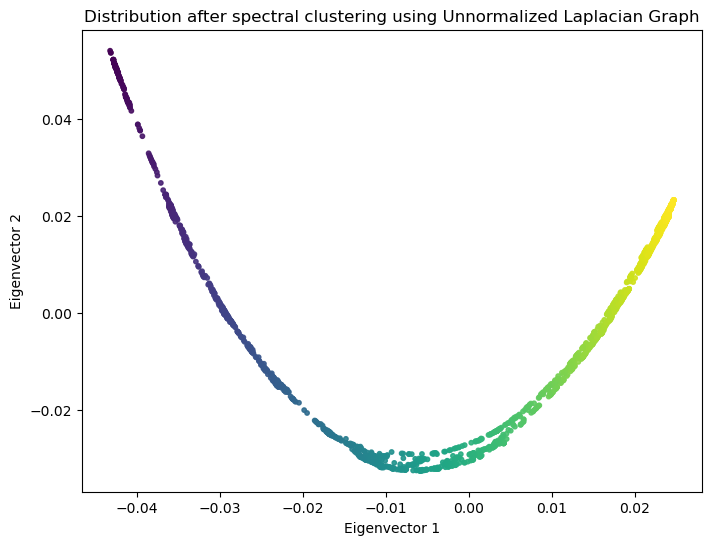

In [1024]:
plt.figure(figsize=(8,6))
plt.scatter(x=two_eig_df_2['eigenvect1'], y=two_eig_df_2['eigenvect2'], marker='o', alpha=0.9, c=two_eig_df_2['eigenvect1'], cmap='viridis',s=10)
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.title('Distribution after spectral clustering using Unnormalized Laplacian Graph')
plt.show()

In [1025]:
epsilon = 1e-12

# Count eigenvalues close to zero
zero_eigenvalues = np.sum(np.abs(eigenvals) < epsilon)
print(f"Number of zero eigenvalues: {zero_eigenvalues}")

Number of zero eigenvalues: 1


In [1026]:
D_inv_sqrt_2 = np.diag(1.0 / np.sqrt(np.diag(degree_matrix_2)))

normalized_L_2 = D_inv_sqrt_2@unnorm_laplacian_matrix_2@D_inv_sqrt_2
np.isinf(D_inv_sqrt_2).sum()

0

In [1027]:
np.isnan(normalized_L_2).sum()

0

In [1028]:
norm_eigenvals_2, norm_eigenvects_2 = eigenspace_calculation(matrix=normalized_L_2, k=11)

In [1029]:
norm_eigenvector_1=norm_eigenvects_2[:,1]
norm_eigenvector_2=norm_eigenvects_2[:,2]

In [1030]:
norm_two_eig_df_2 = pd.DataFrame(np.column_stack((norm_eigenvector_1, norm_eigenvector_2)), columns=['eigenvect1', 'eigenvect2'])

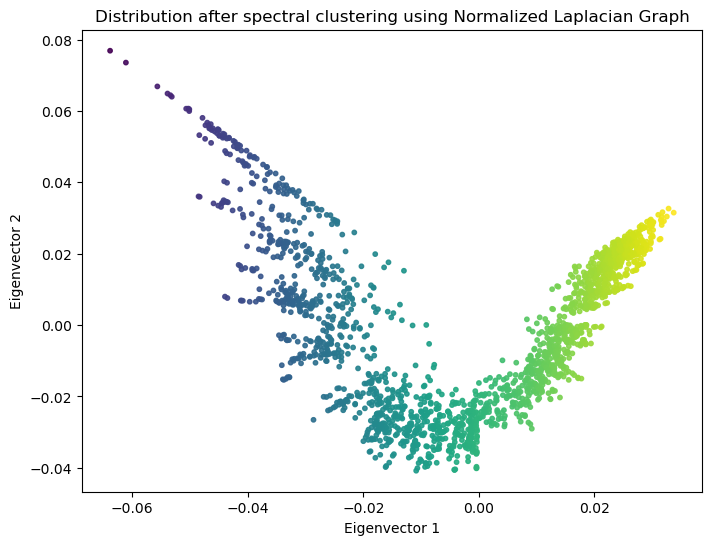

In [1031]:
plt.figure(figsize=(8,6))
plt.scatter(x=norm_two_eig_df_2['eigenvect1'], y=norm_two_eig_df_2['eigenvect2'], marker='o', alpha=0.9, c=norm_two_eig_df_2['eigenvect1'], cmap='viridis', s=10)
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.title('Distribution after spectral clustering using Normalized Laplacian Graph')
plt.show()